In [75]:

import os, sys, time, datetime, random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from torch.utils.data import DataLoader

from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import model as m
import utils
import numpy as np

In [248]:
size_IMG = 24
depth_1 = 16
depth_2 = 16
num_classes = 1950

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, depth_1, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(depth_1, depth_2, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(int(size_IMG ** 2 / 16) * depth_2, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        # conv_x = self.layer2[0](out)

        out = self.layer2(out)
        # max_pool_x = out

        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)

        out = self.fc1(out)
        out = self.fc2(out)

        return out#, conv_x, max_pool_x

In [249]:
model = torch.load("conv_network_model")#, map_location=device)
model.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=576, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1950, bias=True)
)

In [415]:
def make_square(im, min_size=10, fill_color=(255)):
    x, y = im.size
    size = 24#max(min_size, x, y)
    new_im = Image.new('P', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

In [437]:
def cropped_image(img, dl=20, ds=10, dn=2):
    w, h = img.size

    imgs = []
    boxes = []
    for i in range(0,img.size[0]-ds, dn):
        for j in range(0,img.size[1]-ds, dn):
            if j+dl<w:
                box = (i,j,i+ds,j+dl)
                im1 = img.crop(box)
                im1 = make_square(im1)
                
                imgs.append(im1)
                boxes.append(box)
                
            if i+dl<h:
                box = (i,j,i+dl,j+ds)
                im1 = img.crop(box)
                
                im1 = make_square(im1)
                imgs.append(im1)
                boxes.append(box)
                
            box = (i,j,i+ds,j+ds)
            im1 = img.crop(box)
            im1 = make_square(im1)
            imgs.append(im1)
            boxes.append(box)

    return imgs, boxes
    

In [463]:
def detect_image(img, size_IMG):
    # scale and pad image
#     print(img.size)
    
    img_transforms= transforms.Compose(
        [transforms.Resize(size_IMG),     
         transforms.ToTensor(),
         ])
    
    # convert image to Tensor
    tensorimage = img_transforms(img).float()
    
   
    outputs = model(tensorimage.view(1,1,size_IMG,size_IMG).cuda())
    if torch.max(F.softmax(outputs))>0.7:

        _, predicted = torch.max(outputs.data, 1)
        print(labels[predicted])
        if labels[predicted] in pianpanglist:
            return labels[predicted]

In [464]:
imgs, boxes = cropped_image(img)

In [465]:
strs = np.loadtxt('pianpang.txt',delimiter='\n',dtype=str)
pianpanglist = []
for stri in list(strs):
    pianpanglist+=stri.split()

In [466]:

print(len(imgs))
labels = np.load("labels.npy")
print(labels)

print(pianpanglist)

153
['一' '丁' '七' ... '姷' '姹' '姺']
['丨', '亅', '丿', '乛', '一', '乙', '乚', '丶', '八', '勹', '匕', '冫', '卜', '厂', '刀', '刂', '儿', '二', '匚', '阝', '丷', '几', '卩', '冂', '力', '冖', '凵', '人', '亻', '入', '十', '厶', '亠', '匸', '讠', '廴', '又', '艹', '屮', '彳', '巛', '川', '辶', '寸', '大', '飞', '干', '工', '弓', '廾', '广', '己', '彐', '彑', '巾', '口', '马', '门', '宀', '女', '犭', '山', '彡', '尸', '饣', '士', '扌', '氵', '纟', '巳', '土', '囗', '兀', '夕', '小', '忄', '幺', '弋', '尢', '夂', '子', '贝', '比', '灬', '长', '车', '歹', '斗', '厄', '方', '风', '父', '戈', '卝', '户', '火', '旡', '见', '斤', '耂', '毛', '木', '肀', '牛', '牜', '爿', '片', '攴', '攵', '气', '欠', '犬', '日', '氏', '礻', '手', '殳', '水', '瓦', '尣', '王', '韦', '文', '毋', '心', '牙', '爻', '曰', '月', '爫', '支', '止', '爪', '白', '癶', '歺', '甘', '瓜', '禾', '钅', '立', '龙', '矛', '皿', '母', '目', '疒', '鸟', '皮', '生', '石', '矢', '示', '罒', '田', '玄', '穴', '疋', '业', '衤', '用', '玉', '耒', '艸', '臣', '虫', '而', '耳', '缶', '艮', '虍', '臼', '米', '齐', '肉', '色', '舌', '覀', '页', '先', '行', '血', '羊', '聿', '至', '舟', '衣', '竹', '自', '羽', '糸', '糹', '貝', 

In [467]:
# print(boxes)
type(img)

PIL.PngImagePlugin.PngImageFile

亻
亻 (0, 0, 10, 20)


/home/wonton/anaconda3/envs/momotorch/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


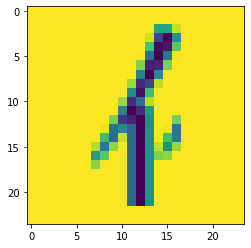

亻
亻 (0, 2, 10, 22)


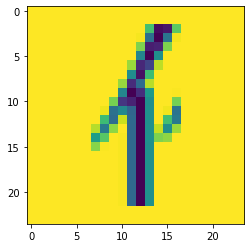

叭
叭
份


In [468]:

for inds,im in enumerate(imgs):
#     print(im.size)
    lab = detect_image(im, img_size) 
    if lab:
        print(lab, boxes[inds])
        plt.imshow(im)
        plt.show()

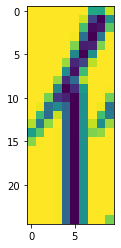

In [258]:
im1 = img.crop((0,0,10,25))
plt.imshow(im1)


(28, 28)


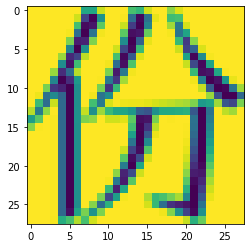

In [25]:
# load image and get detections
data_path = '/home/wonton/jiayi/projects/Chinese-charactor-classification-before202001/commoncharacter>500/'
img_path = data_path + "/份/Angular Handsome Song Chinese Font -Simplified Chinese Fontsttf.png"
prev_time = time.time()
img = Image.open(img_path)
print(img.size)
plt.imshow(img)
